In [1]:
from votekit import load_csv, remove_noncands
from votekit.elections import STV, fractional_transfer, random_transfer
import pandas as pd
import jsonlines
import random
import pickle
import os

In [2]:
WRITEINS = [f'Write-In {i}' for i in range(1,10)]
WRITEINS += ['WI0']
WRITEINS += [f'WI0{i}' for i in range(1,10)]

def break_ties(output):
    correct_output = {}
    for result in output:
        ranking_vector = result['ranking']
        new_ranking = []
        for position in ranking_vector:
            if position in WRITEINS:
                continue
            if isinstance(position, list):
                random.shuffle(position)
                new_ranking += position
            else:
                new_ranking.append(position)
        if tuple(new_ranking) not in correct_output:
            correct_output[tuple(new_ranking)] = 0
        correct_output[tuple(new_ranking)] += 1

    return correct_output


def map_to_irv(output_dict, year):
    profile = load_csv(f'../data/cambridge_{year}.csv')
    to_remove = ['skipped', '0)']
    cambridge = remove_noncands(profile, to_remove)

    irv_election = STV(cambridge,transfer=random_transfer, seats=9, ballot_ties=False)
    irv_ranking = irv_election.run_election().to_dict(keep=['ranking'])['ranking']

    irv_map = {cand: rank+1 for rank, cand in enumerate(irv_ranking)}

    new_output = {}
    for ranking_vector, weight in output_dict.items():
        new_ranking = []
        for cand in ranking_vector:
            new_ranking.append(irv_map[cand])
        new_output[tuple(new_ranking)] = weight

    return new_output

def concate_dicts(list_of_dicts, n):
    master_dict = {}
    for sub_dict in list_of_dicts:
        for ranking, weight in sub_dict.items():
            ranking = ranking[:n]
            if ranking not in master_dict:
                master_dict[ranking] = 0
            master_dict[ranking] += weight

    return master_dict

In [3]:
outputs = []

for year in range(2003, 2017+1, 2):
    results = []
    with jsonlines.open(f'../output/NEW_random_cambridge_{year}.jsonl') as r:
        for line in r:
            results.append(line)

    clean = break_ties(results)
    print(year)
    outputs.append(map_to_irv(clean, year))

2003
2005
2007
2009
2011
2013
2015
2017


In [4]:
full = concate_dicts(outputs, n=15)

In [5]:
with open('results_jan/all_years.pkl', 'wb') as f:
    pickle.dump(full, f)

In [6]:
def find_m_winners(output, m):
    m_winners = {}
    for ranking_vector, weigth in output.items():
        m_set = ranking_vector[:m]
        for cand in m_set:
            if cand not in m_winners:
                m_winners[cand] = 0
            m_winners[cand] += weigth

    return m_winners

In [58]:
find_m_winners(full, 4)

{1: 60000, 2: 60000, 3: 60000, 4: 58981, 6: 551, 5: 141, 7: 327}

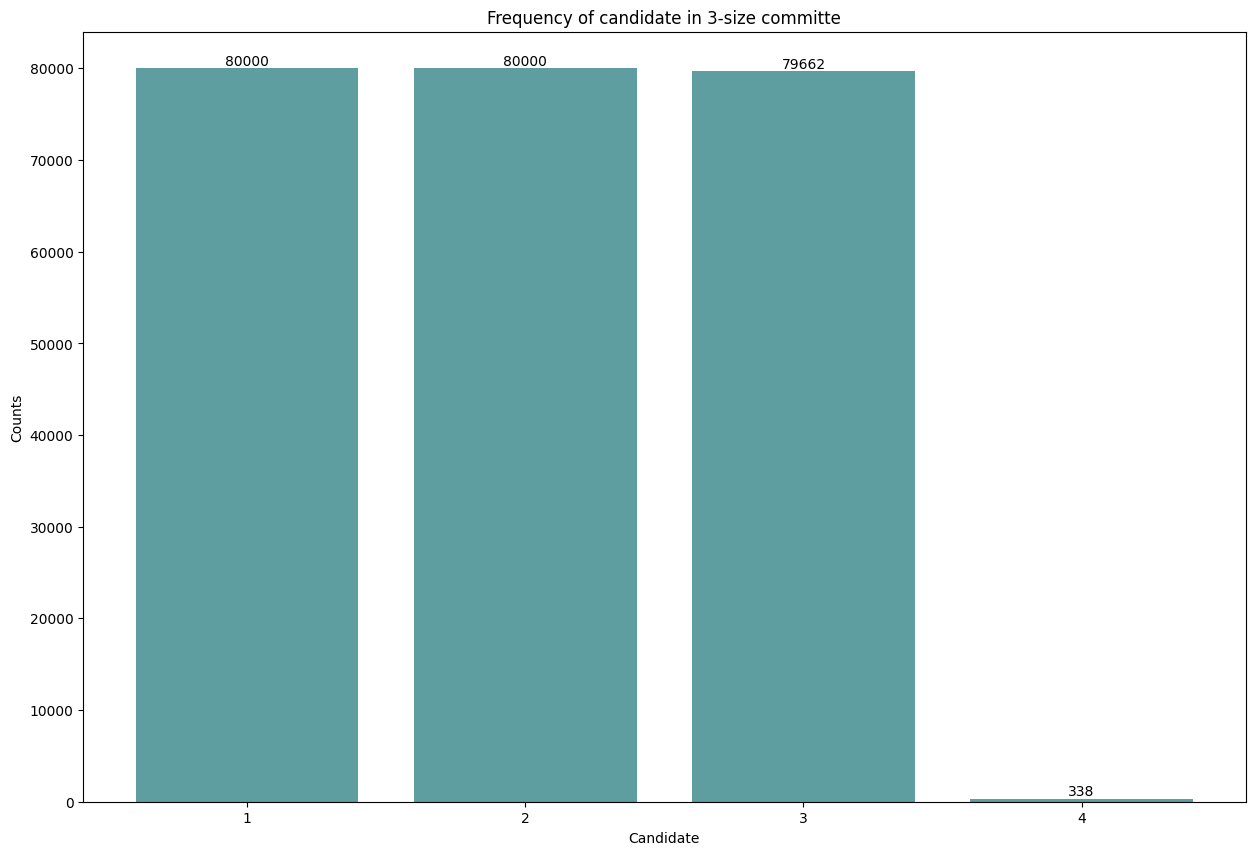

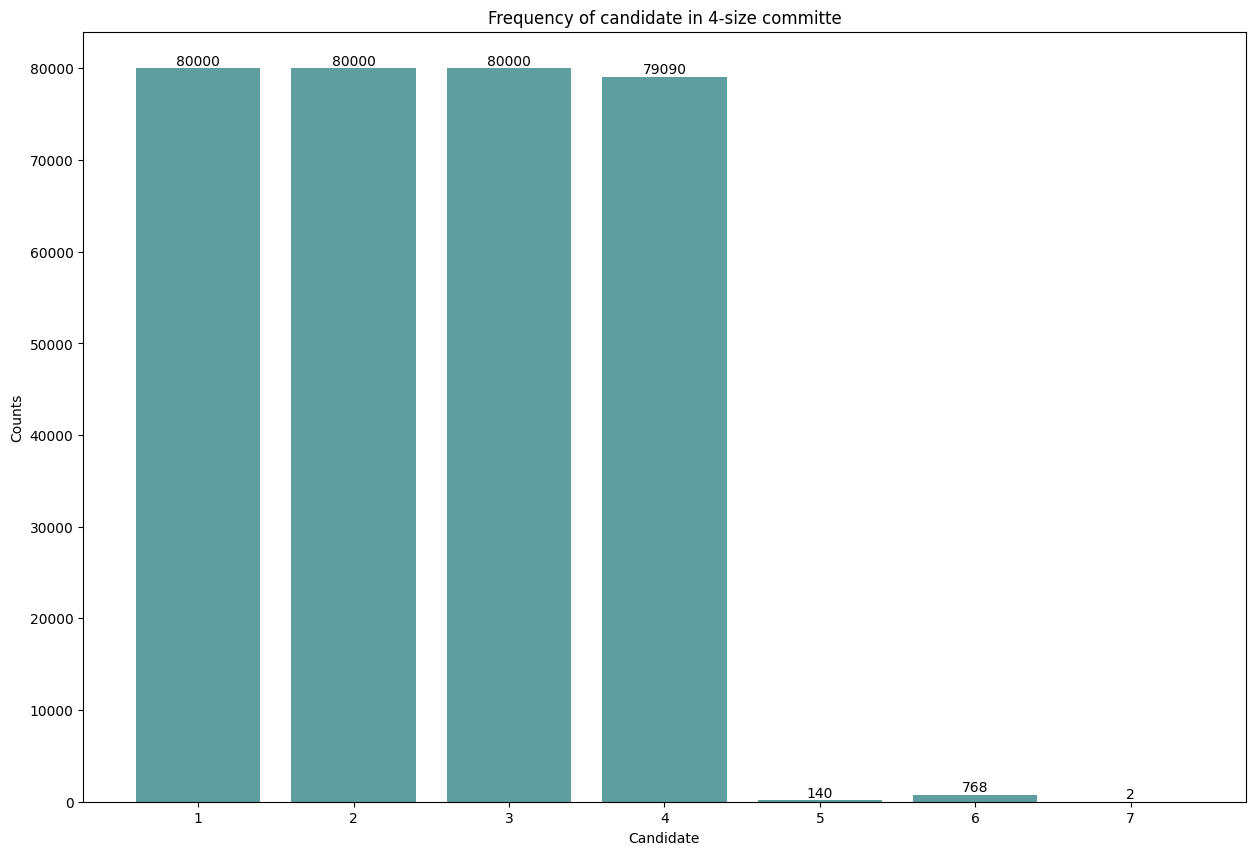

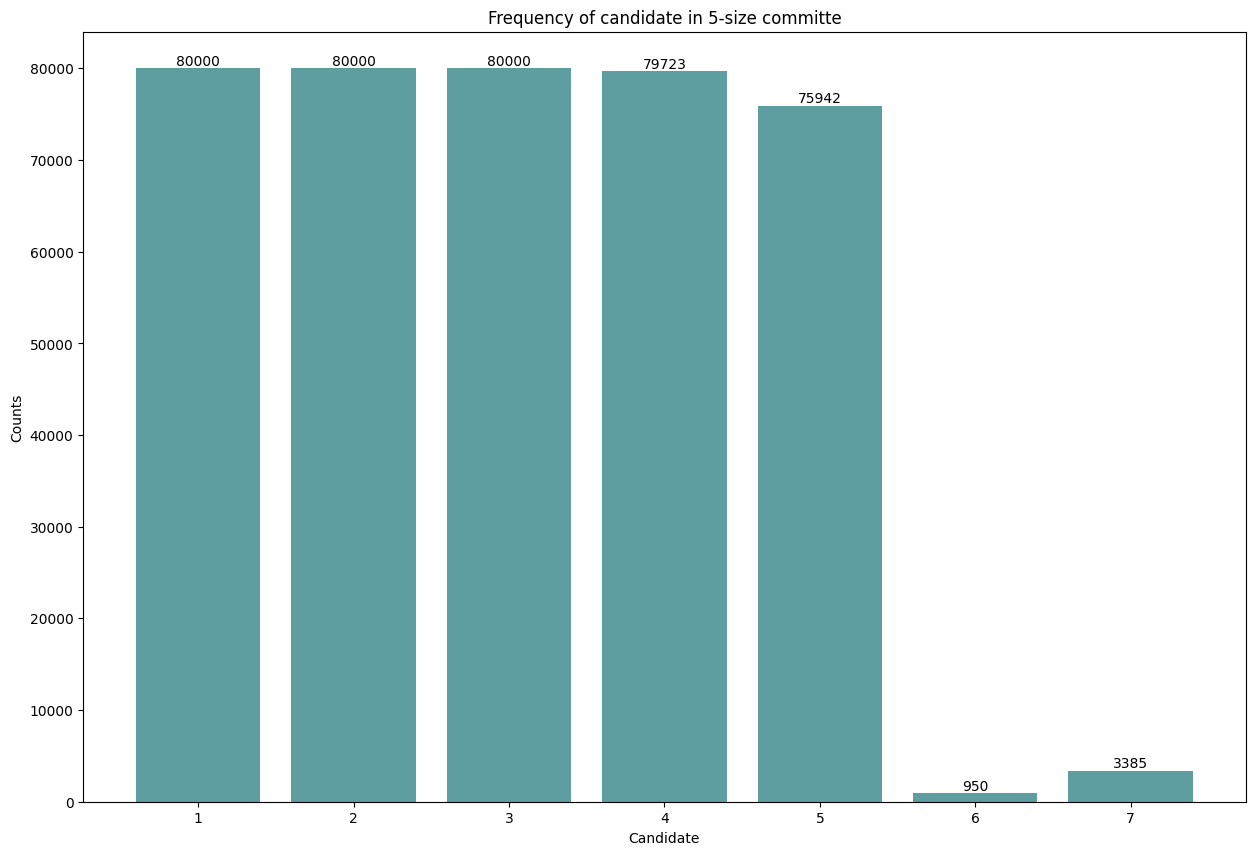

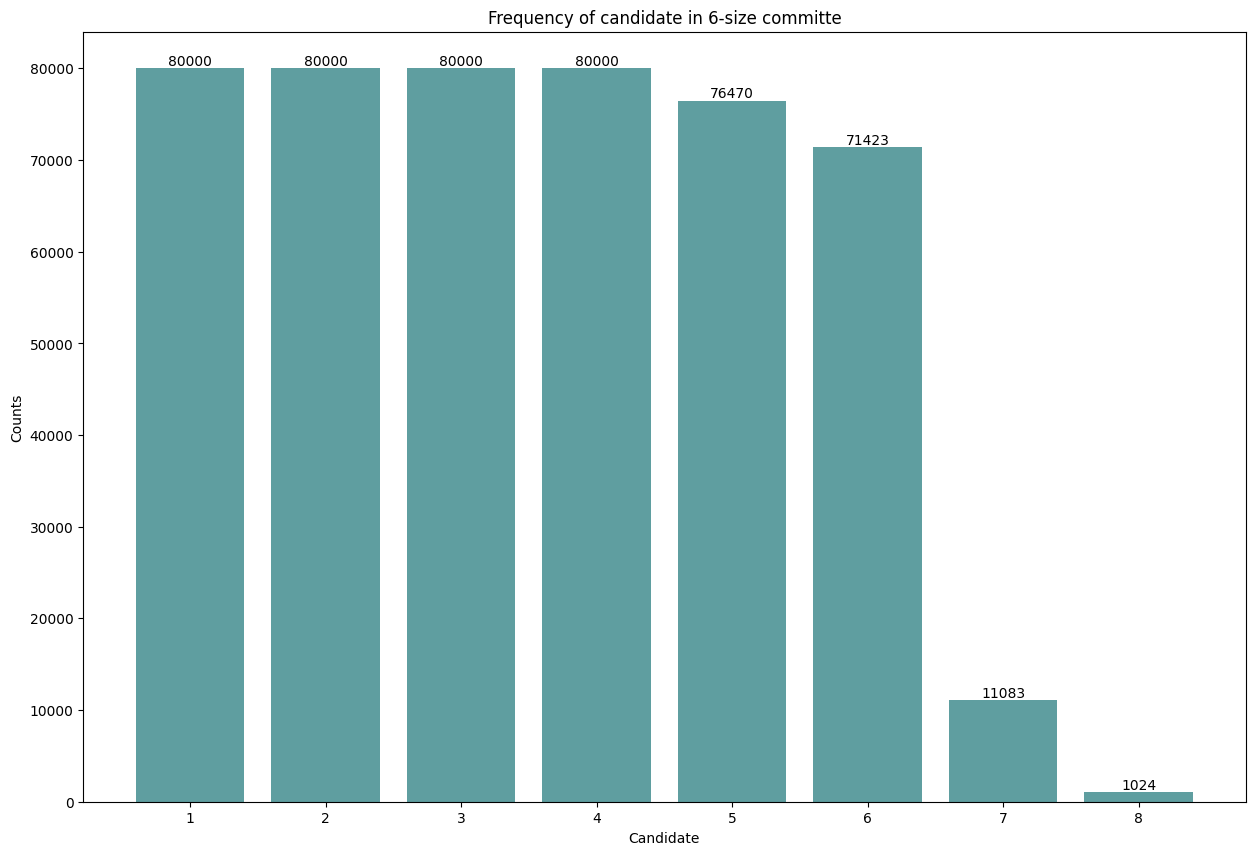

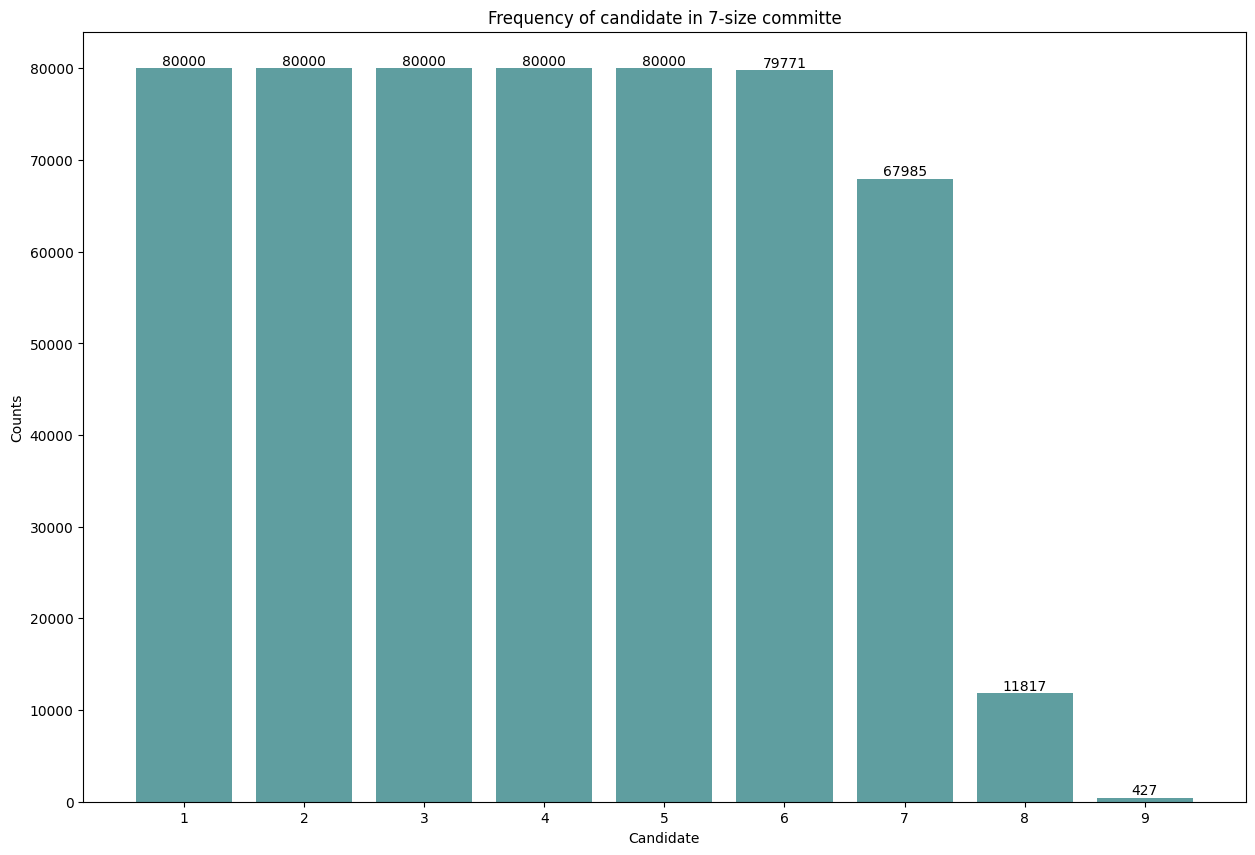

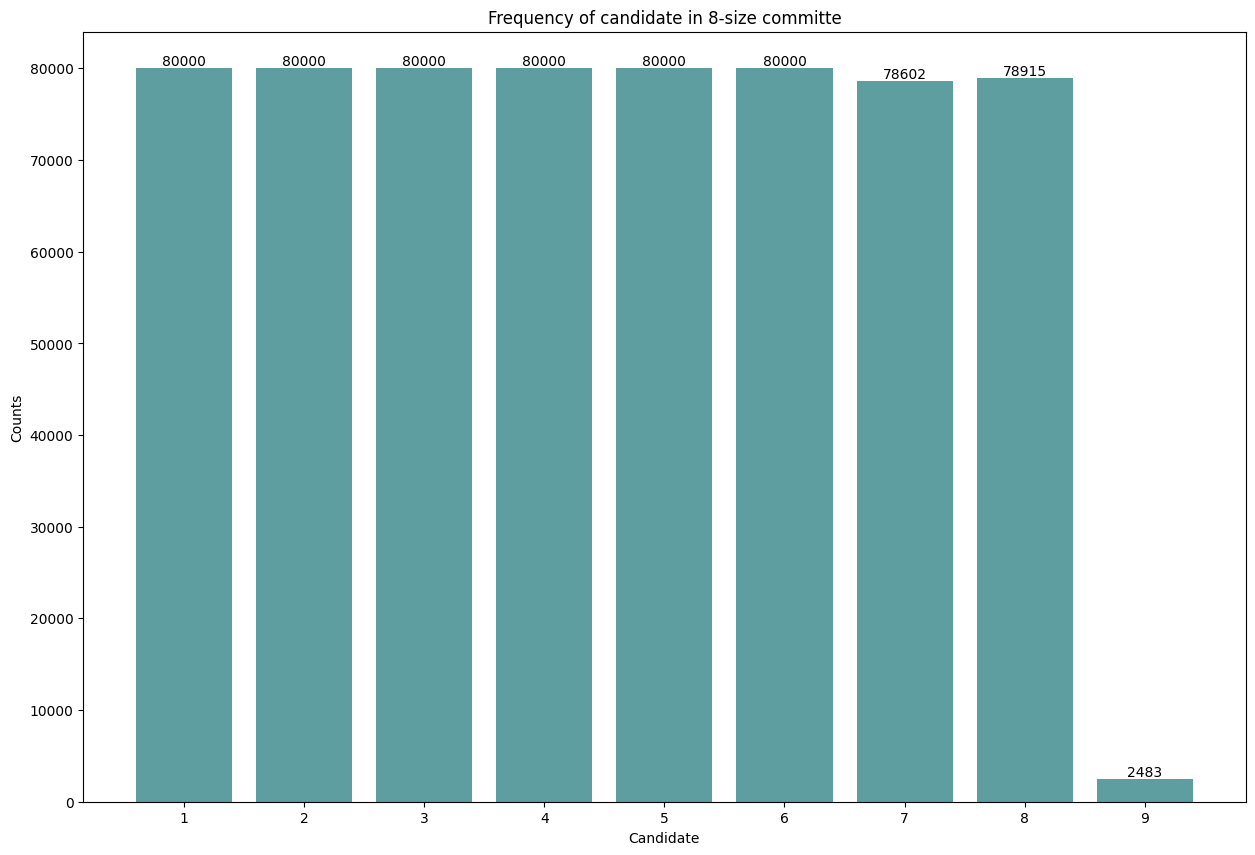

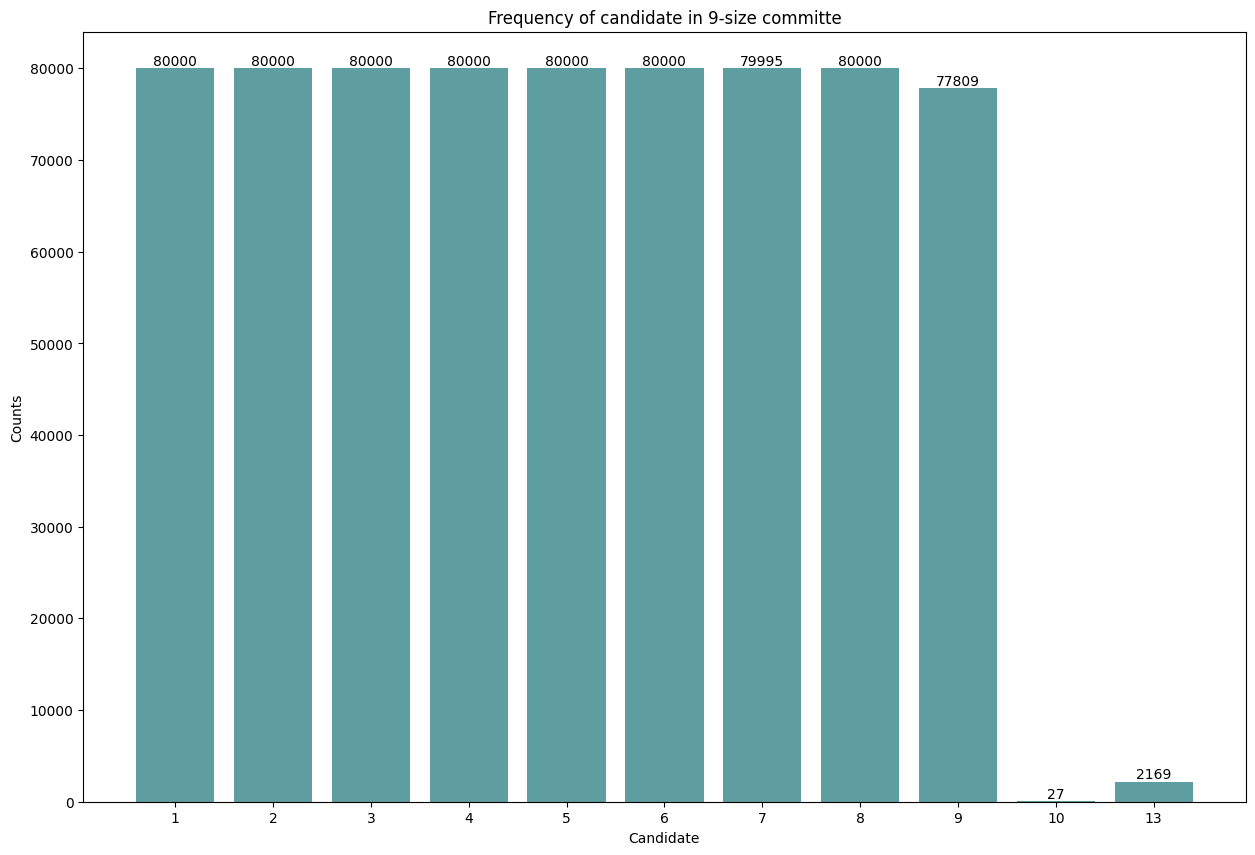

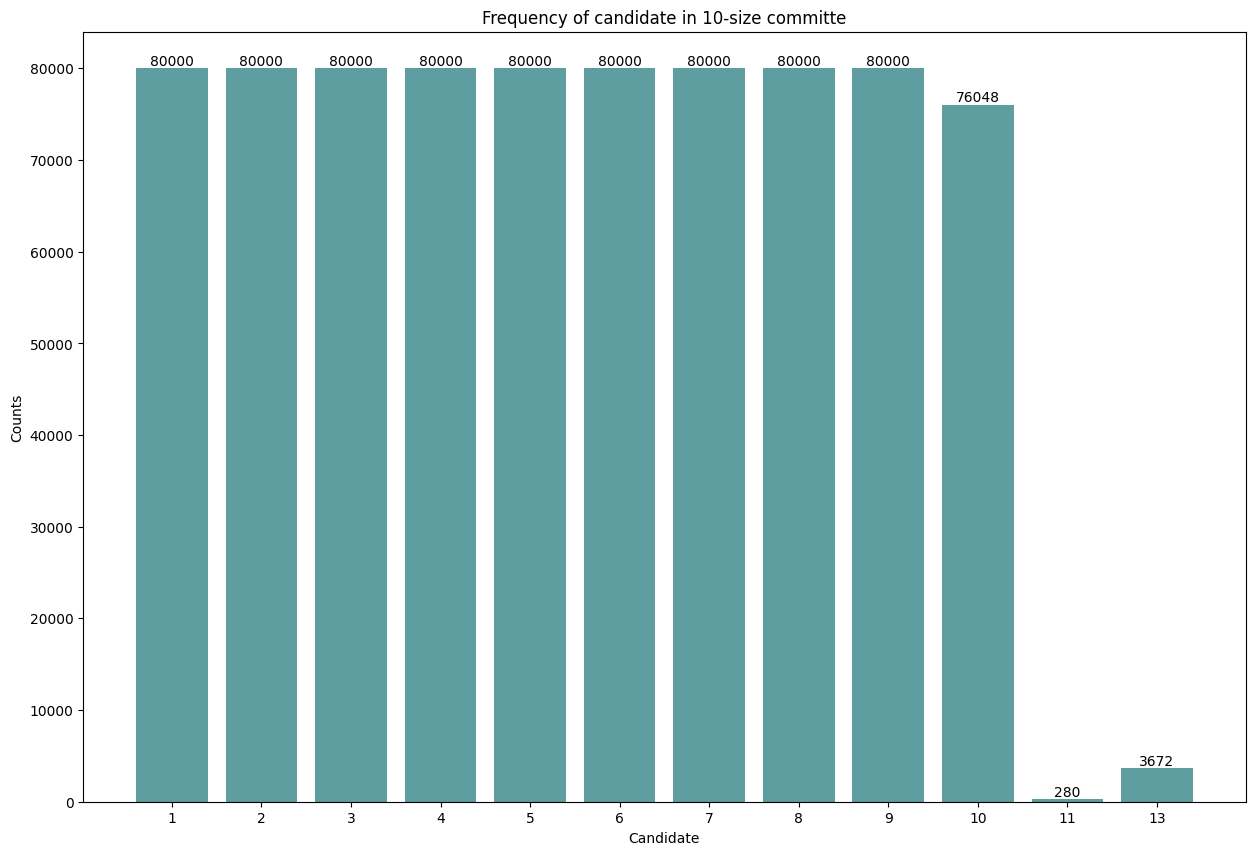

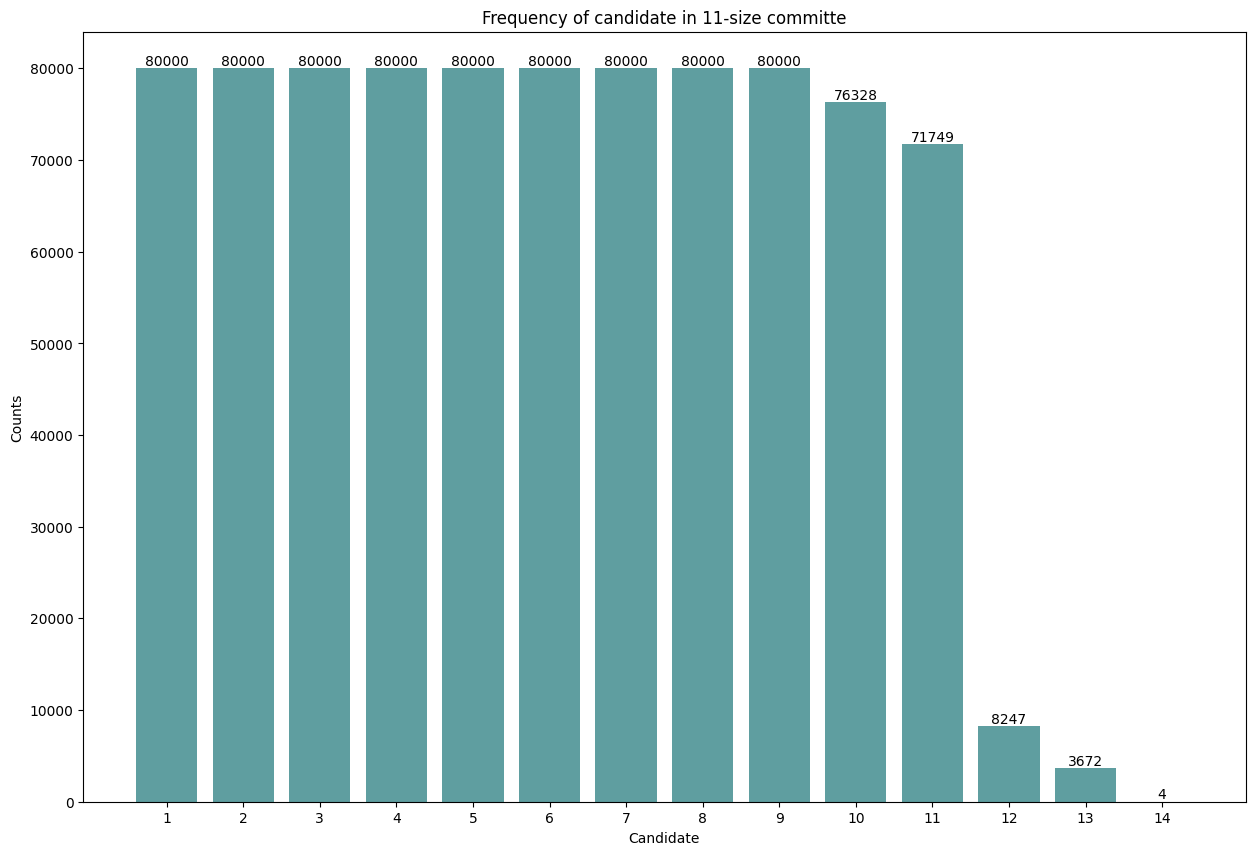

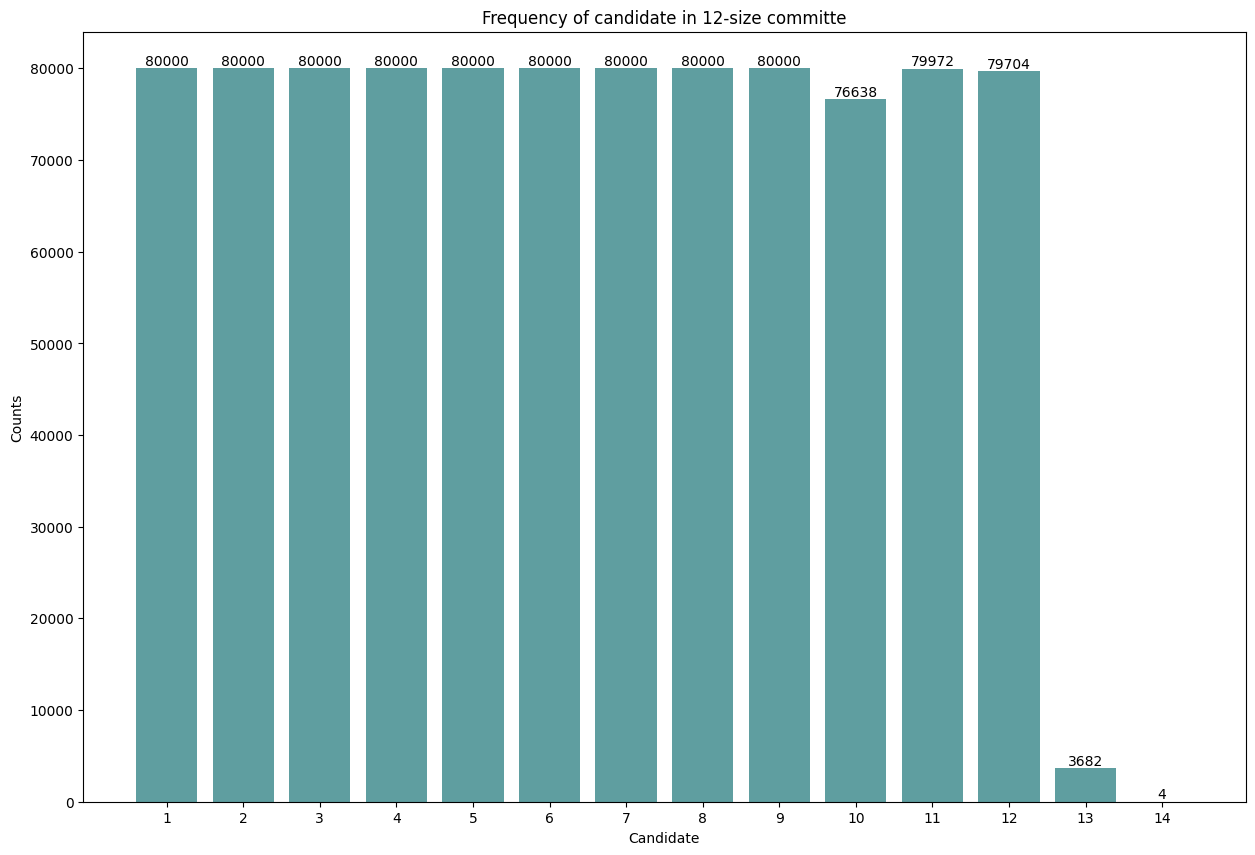

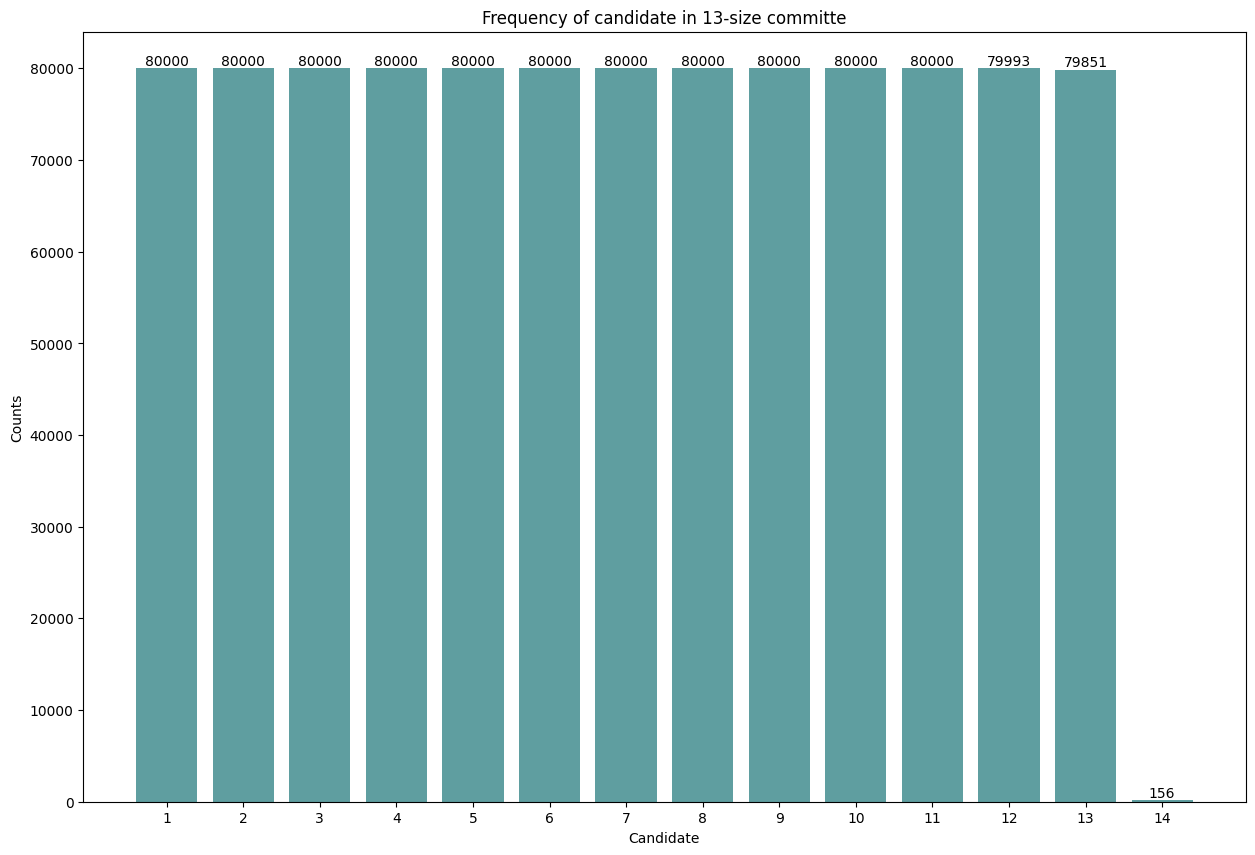

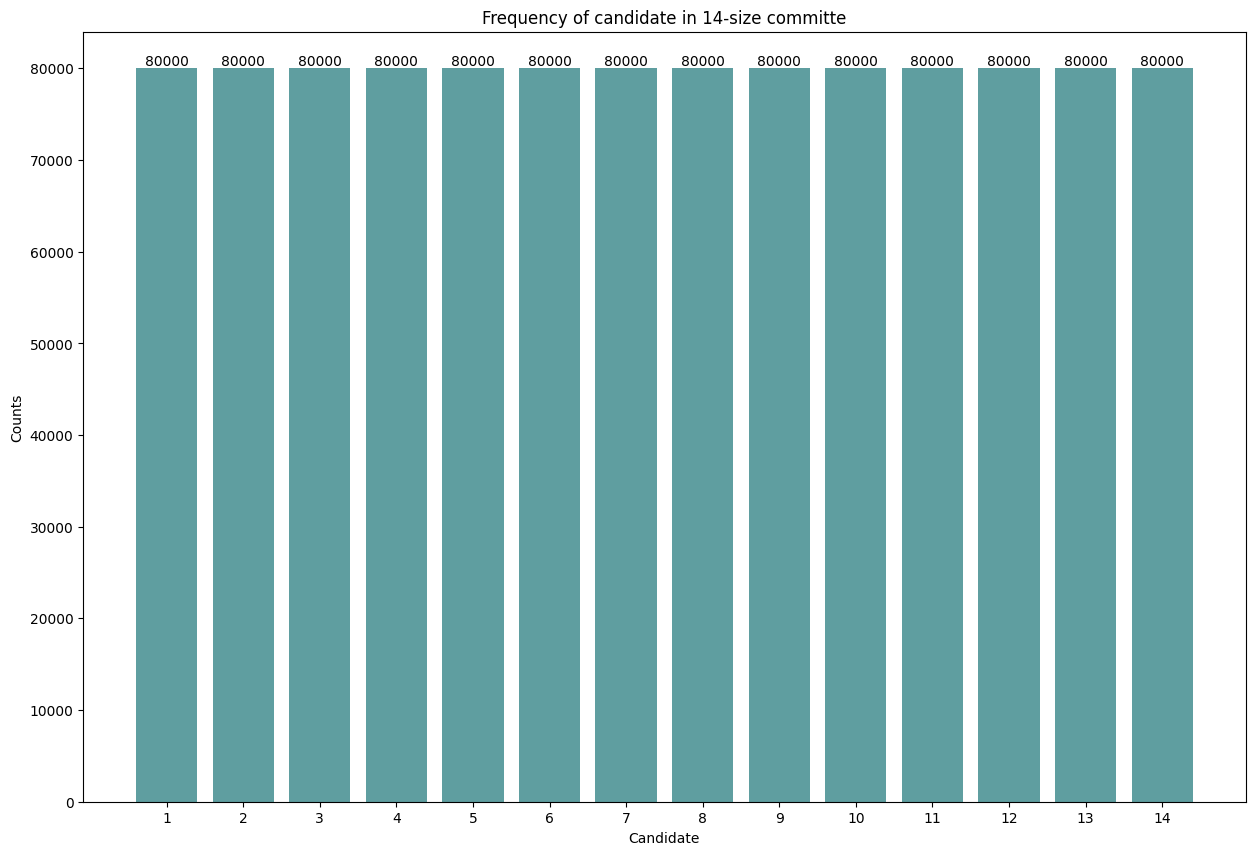

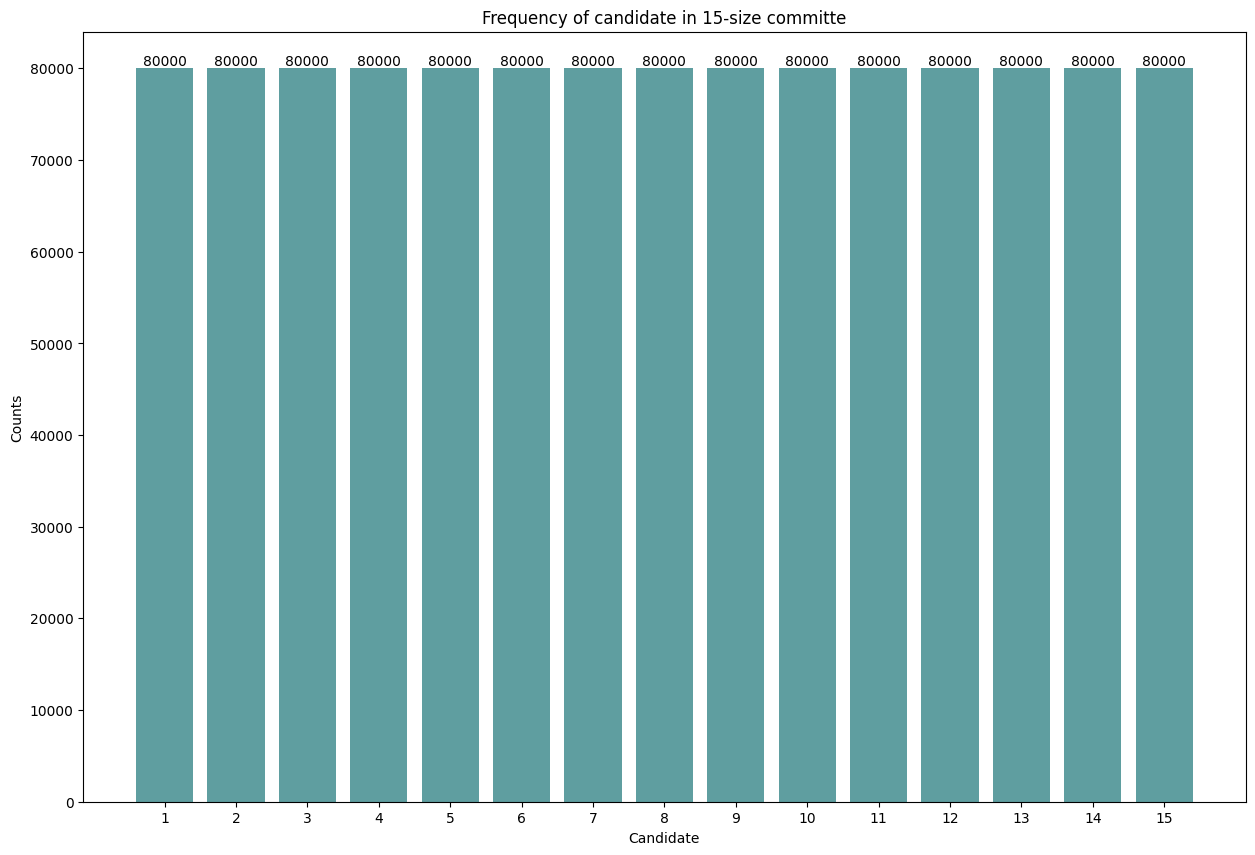

In [7]:
import matplotlib.pyplot as plt
for m in range(3, 16):
    results = find_m_winners(full, m)
    plot_df = pd.DataFrame(data={'cand': list(results.keys()), 'counts': list(results.values())})
    plot_df = plot_df.sort_values(by='cand', ascending=True).reset_index()

    fig, ax = plt.subplots(figsize=(15, 10))
    bar_contain = ax.bar(plot_df['cand'].astype(str), plot_df['counts'], color='cadetblue')
    ax.set(ylabel='Counts', xlabel='Candidate', title=f'Frequency of candidate in {m}-size committe')
    ax.bar_label(bar_contain)
    os.makedirs('plots_jan/all_years', exist_ok=True)
    fig.savefig(f'plots_jan/all_years/{m}_size_committe.png', dpi=600)